In [152]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [153]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss as mpl
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [444]:
# Here we generate some pseudodata that follows a linear trend
# The inputs are sampled uniformly over a range.
def f(x):
    """The function to predict."""
    return -3*x**2 + 12.67*x - 3.95


xLimMin = 0
xLimMax = 3
npts    = 100

seed       = 42
rng        = np.random.RandomState(seed)

X          = np.atleast_2d(rng.uniform(xLimMin, xLimMax, size=npts)).T # (100,1)
expected_y = f(X).ravel() # (100,)

In [445]:
# Creating our noise and noisy data:
noiseScale = 0.05*abs(expected_y)
fractalNoise = rng.normal(0, noiseScale)
y = expected_y + fractalNoise

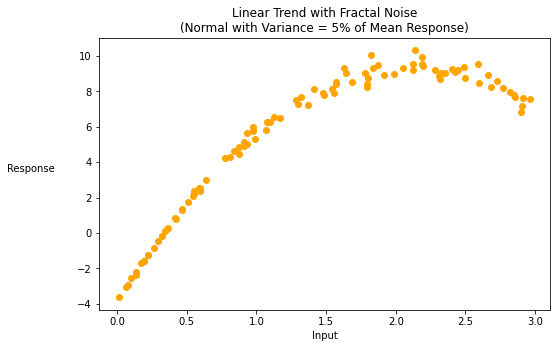

In [446]:
figScale = 0.5
fig, ax = plt.subplots(figsize = figScale*np.array([16.18, 10]))
plt.scatter(X, y, c = 'orange')
plt.title('Linear Trend with Fractal Noise\n(Normal with Variance = 5% of Mean Response)')
plt.xlabel('Input')
plt.ylabel('Response', rotation = 'horizontal')
ax.yaxis.set_label_coords(-0.15,0.5)

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size = 0.15)

In [497]:
# Create quantile models:
all_models = {}
common_params = dict(
    learning_rate=0.01,
    n_estimators=1200,
    subsample = 0.8
)

for alpha in [0.16, 0.5, 0.84]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %.2f" % alpha] = gbr.fit(X_train, y_train)
    

# Create an MSE model for the sake of comparison to tradition:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

In [498]:
# create an evenly spaced domain for the purposes of plotting the predicted response at each point:
num_xx = int((xLimMax-xLimMin)/0.01)
xx     = np.atleast_2d(np.linspace(xLimMin, xLimMax, 100)).T

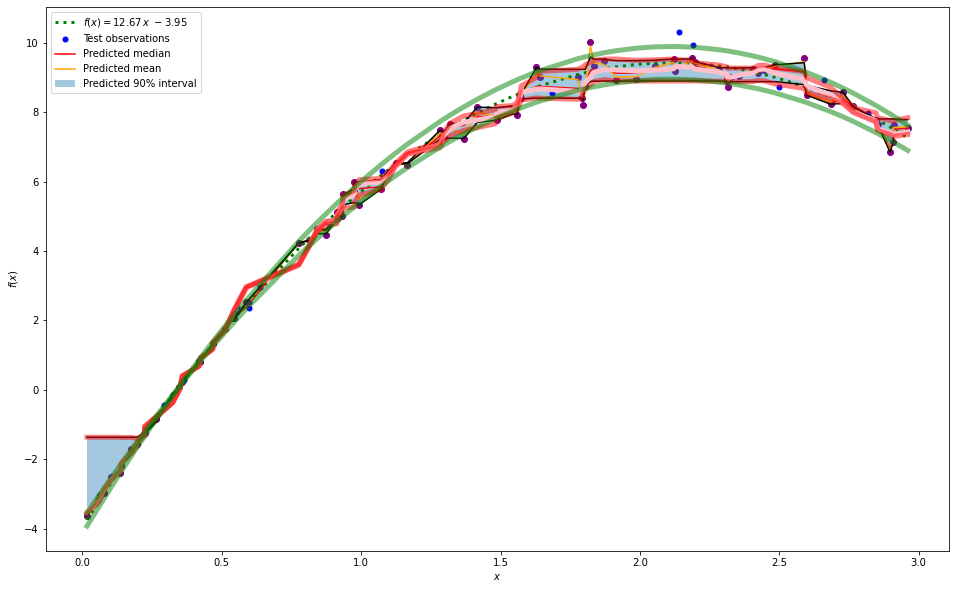

In [499]:
import matplotlib.pyplot as plt
xx = np.atleast_2d(np.sort(X_train.ravel())).T
#xx=np.atleast_2d(np.sort(X_train.ravel())).T
y_pred = all_models["mse"].predict(xx)
y_lower = all_models["q 0.16"].predict(xx)
y_upper = all_models["q 0.84"].predict(xx)
y_med = all_models["q 0.50"].predict(xx)

fig = plt.figure(figsize=(16.18, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = 12.67\,x\,\, -3.95$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "r-", label="Predicted median")
plt.plot(xx, y_pred,c='orange', label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.scatter(X_train, y_train, c = 'purple')
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
#plt.ylim(-10, 25)
plt.legend(loc="upper left")

yupptrue = f(xx) + 0.05*f(xx)
ylowtrue = f(xx) - 0.05*f(xx)
plt.plot
from scipy.signal import savgol_filter
ySmooth = savgol_filter(y_med, 9, 2)
ySmoothUpp = savgol_filter(y_upper, 9, 2)
ySmoothLow = savgol_filter(y_lower, 9, 2)
plt.plot(xx, ySmooth, c='pink',alpha=1, lw = 5)
plt.plot(xx, ySmoothUpp, c='red',alpha=0.5, lw = 5)
plt.plot(xx, ySmoothLow, c='red',alpha=0.5, lw = 5)
plt.plot(xx, yupptrue, c='green',alpha=0.5, lw = 5)
plt.plot(xx, ylowtrue, c='green',alpha=0.5, lw = 5)

plt.show()

In [500]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

In [501]:
m=6
k=15
x=np.array(xx)
# The number of knots can be used to control the amount of smoothness
model_6_upp = get_natural_cubic_spline_model(xx, y_upper, minval=min(xx), maxval=max(xx), n_knots=m)
model_6_low = get_natural_cubic_spline_model(xx, y_lower, minval=min(xx), maxval=max(xx), n_knots=m)

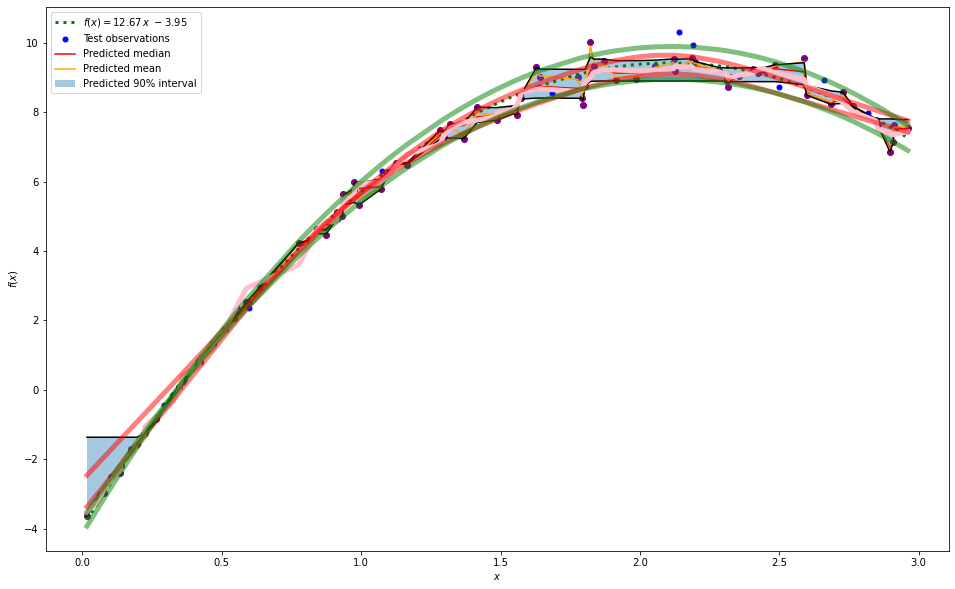

In [502]:
import matplotlib.pyplot as plt
xx = np.atleast_2d(np.sort(X_train.ravel())).T
#xx=np.atleast_2d(np.sort(X_train.ravel())).T
y_pred = all_models["mse"].predict(xx)
y_lower = all_models["q 0.16"].predict(xx)
y_upper = all_models["q 0.84"].predict(xx)
y_med = all_models["q 0.50"].predict(xx)

fig = plt.figure(figsize=(16.18, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = 12.67\,x\,\, -3.95$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "r-", label="Predicted median")
plt.plot(xx, y_pred,c='orange', label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.scatter(X_train, y_train, c = 'purple')
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
#plt.ylim(-10, 25)
plt.legend(loc="upper left")

yupptrue = f(xx) + 0.05*f(xx)
ylowtrue = f(xx) - 0.05*f(xx)
plt.plot
from scipy.signal import savgol_filter
ySmooth = savgol_filter(y_med, 9, 2)
ySmoothUpp = savgol_filter(y_upper, 9, 2)
ySmoothLow = savgol_filter(y_lower, 9, 2)
plt.plot(xx, ySmooth, c='pink',alpha=1, lw = 5)
plt.plot(xx, model_6_upp.predict(xx), c='red',alpha=0.5, lw = 5)
plt.plot(xx, model_6_low.predict(xx), c='red',alpha=0.5, lw = 5)
plt.plot(xx, yupptrue, c='green',alpha=0.5, lw = 5)
plt.plot(xx, ylowtrue, c='green',alpha=0.5, lw = 5)

plt.show()

In [451]:
import pandas as pd


def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results = []
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    y_pred = gbr.predict(X_train)
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_train, y_pred, alpha=alpha)
    metrics["MSE"] = mean_squared_error(y_train, y_pred)
    results.append(metrics)

pd.DataFrame(results).set_index("model").style.apply(highlight_min)

,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,0.048272,0.050111,0.051950,0.015598
q 0.16,0.019653,0.099819,0.179985,0.098303
q 0.50,0.053755,0.064737,0.075719,0.039071
q 0.84,0.396575,0.213794,0.031012,0.630877


In [452]:
xLeft  = np.linspace(-3, 0, 1000)
xRight = np.linspace(0 , 3, 1000)
alpha = 0.8
yLeft = np.exp(-(1-alpha)*(xLeft)**2)
yRight = np.exp(-(alpha)*(xRight)**2)




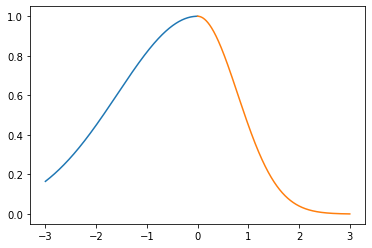

In [453]:
plt.plot(xLeft, yLeft, label = 'squared left')
plt.plot(xRight, yRight, label = 'squared right')

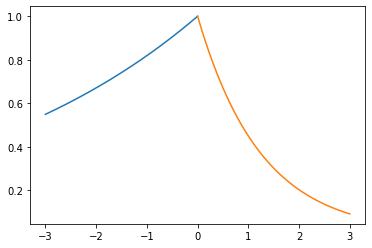

In [454]:
yLeftLap = np.exp(-(alpha-1)*xLeft)
yRightLap = np.exp(-(alpha)*xRight)

plt.plot(xLeft, yLeftLap)
plt.plot(xRight, yRightLap)

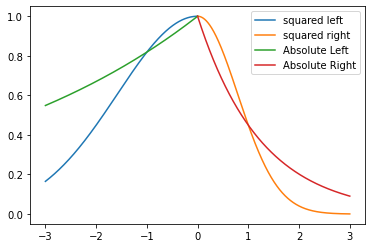

In [455]:
plt.plot(xLeft, yLeft, label = 'squared left')
plt.plot(xRight, yRight, label = 'squared right')
plt.plot(xLeft, yLeftLap, label = 'Absolute Left')
plt.plot(xRight, yRightLap, label = 'Absolute Right')

plt.legend()